In [ ]:
# Name: Sitong Mu; Github username: edsml-sm1122

The file   
1. read and preprocess elavation and distance data and build two new dataset (old data+distance; old data+elavation)
2. train several models using new dataset and test the models' generalization on space

In [ ]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 7.4 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import *

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
# read the elevation data and points location data
ele = np.load('/content/drive/MyDrive/IRP/data/20230608/Loc0mEle.npy')
loc0 = np.load('/content/drive/MyDrive/IRP/data/20230608/Loc0m.npy')
loc25 = np.load('/content/drive/MyDrive/IRP/data/20230608/Loc25m.npy')

# prepare elevation data
ele = ele[:,-1]  # inverse to make the caostline point index match offshore
elemean = ele.mean()  #normalizations
elestd = ele.std()
ele = (ele-elemean)/elestd

In [ ]:
loc0 =loc0[::-1] # inverse the coastline point index from n2s to s2n

In [ ]:
import math

def haversine_distance(loc1, loc2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Parameters:
    - loc1, loc2: Two locations in the format [ID, latitude, longitude].

    Returns:
    - Distance in kilometers.
    """

    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1 = math.radians(loc1[1])
    lon1 = math.radians(loc1[2])
    lat2 = math.radians(loc2[1])
    lon2 = math.radians(loc2[2])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance


In [ ]:
# form lat,lon to distance
loc25 = loc25[5:-5]
hor_dis = np.array([ haversine_distance(loc0[i], loc25[i]) for i in range(len(loc0))])

# normalize distance
dismean = hor_dis.mean()
disstd = hor_dis.std()
hor_dis = (hor_dis-dismean)/disstd

In [ ]:
#read the old 6 parameters data, splite the data into 5 chunks by location

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
# m25del = m25[[45,83,77],...]
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
# m0del = m0[[45,83,77],...]
m0 = np.delete(m0, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m0)}")


m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#  chucnk the tar
tar = m0[:,:,:,2]
print(tar.shape)
tar = np.reshape(tar,(np.shape(tar)[0],np.shape(tar)[1],int(np.shape(tar)[2]/5), 5))

tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2],np.shape(tar)[3]))
print(f"After reshaping: {tar_rs.shape}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"After reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
print('after FE')
feature25m = convert_deg_to_sin_cos(feature25m)

# chunk the features
feature25m = np.reshape(feature25m,(np.shape(feature25m)[0],int(np.shape(feature25m)[1]/5),5, np.shape(feature25m)[-1]))
feature25m = np.transpose(feature25m, (0, 1, 3, 2))
print(feature25m.shape)

#further reshape
print('Final reshaping')
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2],feature25m.shape[-1])
print(feature25m.shape)

tar_rs[np.isnan(tar_rs)] = 0
tar_rs = np.flip(tar_rs,axis=2)# as the index order of points is opposite for coastline and offshore, flip the offshore points by space index

Before reshaping: (185, 98, 155, 6)
Before reshaping: (185, 98, 145, 6)
(185, 97, 145)
After reshaping: (17945, 29, 5)
After reshaping: (17945, 155, 6)
after FE
(17945, 31, 8, 5)
Final reshaping
(17945, 248, 5)


In [ ]:
# conbine elavation, distance with olad data, respectively
ele_rs = torch.tensor(ele).unsqueeze(0).expand(len(feature25m), -1)
ele_rs_ = np.reshape(ele_rs,(ele_rs.shape[0],int(ele_rs.shape[1]/5),5))
chunksele = np.concatenate((feature25m, ele_rs_), axis=1)

dis_rs = torch.tensor(hor_dis).unsqueeze(0).expand(len(feature25m), -1)
dis_rs_ = np.reshape(dis_rs,(dis_rs.shape[0],int(dis_rs.shape[1]/5),5))
chunksdis = np.concatenate((feature25m, dis_rs_), axis=1)

In [ ]:
# model class with flexible input and output shape

class simpleFFN(nn.Module):
  def __init__(self,indim,outdim):
    super(simpleFFN, self).__init__()
    self.hidden_1 = nn.Linear(indim, 50, bias=False) ### changing the size of the layers, though input a batch, here the layer does not related to the batch(but the first dim of the tenser propagated in the net always the batch size)
    self.hidden_2 = nn.Linear(50, 50, bias=False) ### changing the size of the layers
    self.hidden_3 = nn.Linear(50,50)               ### added layer
    self.output = nn.Linear(50, outdim, bias=False)
    self.activation = nn.LeakyReLU()

  def forward(self, X):
    z1 = self.hidden_1(X)
    a1 = self.activation(z1)
    z2 = self.hidden_2(a1)
    a2 = self.activation(z2)
    z3 = self.hidden_3(a2)    ### modified forward pass to use the new layer
    a3 = self.activation(z3)  ### activate the output of the new layer
    z4 = self.output(a3)      ### and now pass it to the output layer
    a4 = self.activation(z4)
    return a4                 ### something is wrong here! what??


In [ ]:
# set hyperparameters, then train several (6)  models (3 models for each dataset (2 in total), '3' as using chunk 0,2,4)
seed = 42
lr = 1e-4
# momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 100

In [ ]:
def trainwithout(feature,target):
     """
    Train a simple Feed Forward Neural Network (FFN) on given features and targets.
    The function uses the Mean Squared Error (MSE) loss and Adam optimizer.

    Steps:
    1. Normalizes the feature matrix.
    2. Splits the data into training and testing sets.
    3. Creates DataLoader objects for training and validation.
    4. Initializes the FFN model and moves it to the device (presumably GPU).
    5. Trains the model using batches from DataLoader and updates the model parameters.
    6. Validates the model on the validation set.
    7. Plots the training and validation losses during training.

    Note:
    - This function uses global variables for batch_size, test_batch_size, n_epochs, and device.
      Ensure these are available in your workspace.
    """
  # use the 25m as train set
    mean,std,feature = normalize(feature)
    # mean50m,std50m,feature50m = normalize(feature50m[...,2])

    indim = feature.shape[-1]
    outdim = target.shape[-1]
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)

    traindata = MLPDataset(X_train,y_train)
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    valdata = MLPDataset(X_test,y_test)

    model = simpleFFN(outdim=outdim,indim=indim).to(device)                                              # instantiate model and send it to the GPU
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # instantiate the optimizer
    # optimizer = torch.optim.Adam(model.parameters(),momentum=momentum)   # instantiate the optimizer
    criterion = nn.MSELoss()

    train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
    validation_loader = DataLoader(valdata, batch_size=test_batch_size, shuffle=False, num_workers=0)

    # built in lr (e-4)
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
    liveloss = PlotLosses()    # plots evolution of loss and accuracy
    for epoch in range(n_epochs):
        logs = {}
        train_loss= torch.sqrt(mlptrain(model, optimizer, criterion, train_loader,device=device))

        logs['' + 'log loss'] = train_loss.item()
        # logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss= torch.sqrt(mlpvalidate(model, criterion, validation_loader,device=device))
        logs['val_' + 'log loss'] = validation_loss.item()
        # logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        print(validation_loss.item())


    return mean, std, model

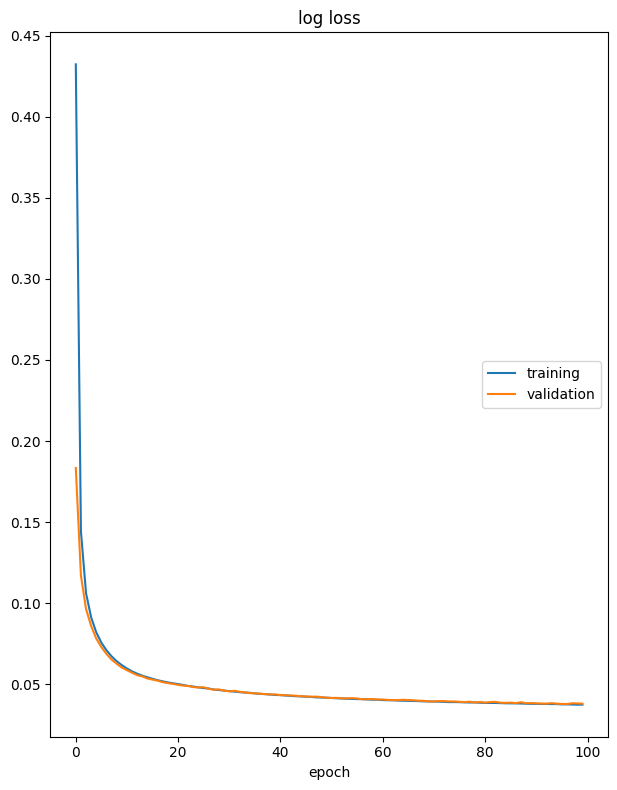

log loss
	training         	 (min:    0.037, max:    0.432, cur:    0.037)
	validation       	 (min:    0.038, max:    0.183, cur:    0.038)
0.03799550607800484


In [ ]:
meanmidele, stdmidele, modelmidele = trainwithout(chunksele[...,2],tar_rs[...,2])# use the 3rd chunk to train a model

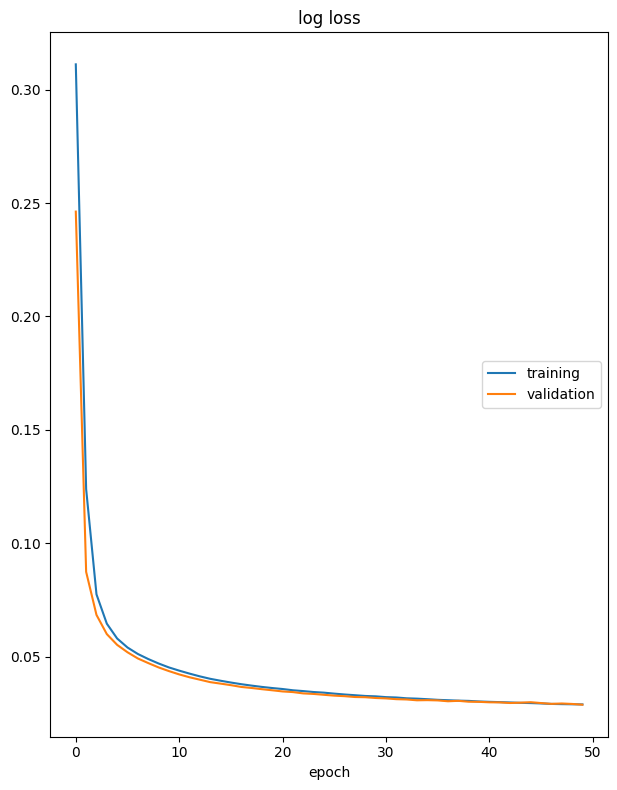

log loss
	training         	 (min:    0.029, max:    0.311, cur:    0.029)
	validation       	 (min:    0.029, max:    0.246, cur:    0.029)
0.028827738016843796


In [ ]:
meanleftele, stdleftele, modelleftele = trainwithout(chunksele[...,0],tar_rs[...,0])# use the 3rd chunk to train a model

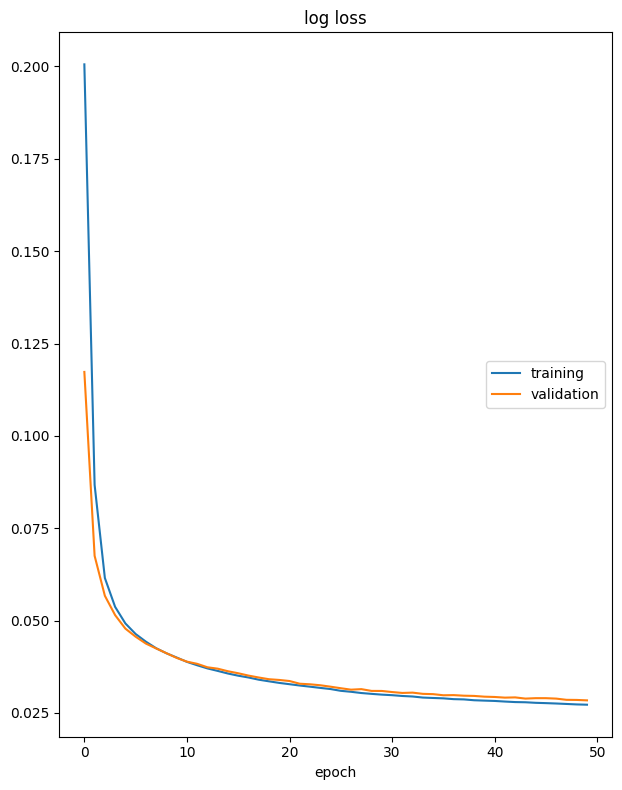

log loss
	training         	 (min:    0.027, max:    0.201, cur:    0.027)
	validation       	 (min:    0.028, max:    0.117, cur:    0.028)
0.028409501537680626


In [ ]:
meanrightele, stdrightele, modelrightele = trainwithout(chunksele[...,-1],tar_rs[...,-1])# use the 3rd chunk to train a model

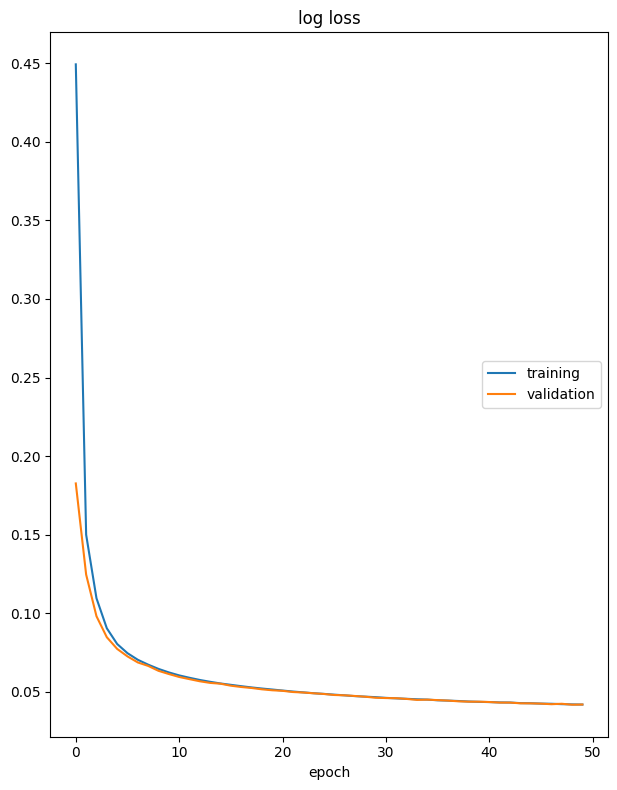

log loss
	training         	 (min:    0.042, max:    0.449, cur:    0.042)
	validation       	 (min:    0.042, max:    0.183, cur:    0.042)
0.041762154549360275


In [ ]:
meanmiddis, stdmiddis, modelmiddis = trainwithout(chunksdis[...,2],tar_rs[...,2])# use the 3rd chunk to train a model

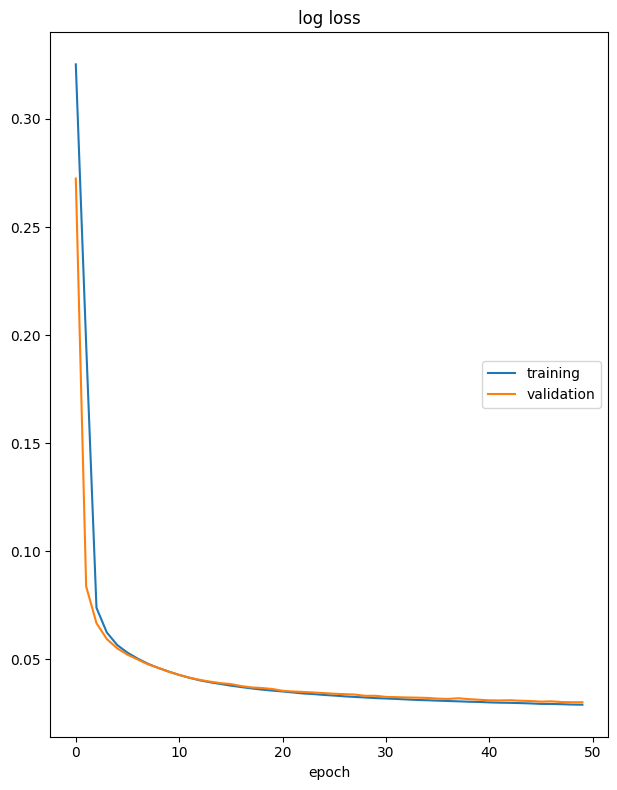

log loss
	training         	 (min:    0.029, max:    0.325, cur:    0.029)
	validation       	 (min:    0.030, max:    0.272, cur:    0.030)
0.030227938666939735


In [ ]:
meanleftdis, stdleftdis, modelleftdis = trainwithout(chunksdis[...,0],tar_rs[...,0])# use the 3rd chunk to train a model

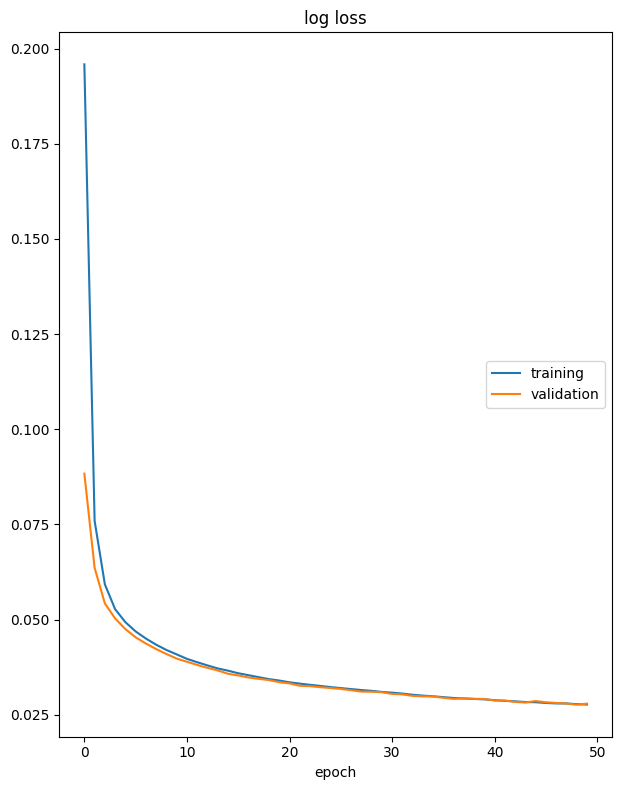

log loss
	training         	 (min:    0.028, max:    0.196, cur:    0.028)
	validation       	 (min:    0.028, max:    0.088, cur:    0.028)
0.027909303084015846


In [ ]:
meanrightdis, stdrightdis, modelrightdis = trainwithout(chunksdis[...,-1],tar_rs[...,-1])# use the 3rd chunk to train a model

The code below test the 6 models on other chunk of data.

In [ ]:
#normalization
import random


def normalize(arr):
    """
    Normalizes a NumPy array.

    Parameters:
    arr (np.array): Input array to be normalized.

    Returns:
    mean (float): Mean of the input array along axis 0.
    std (float): Standard deviation of the input array along axis 0.
    arr_normalized (np.array): Normalized array.

    Note:
    - This function is different from the one in utilities.py
    """
    # Compute mean and std dev
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)

    # Subtract mean and divide by std dev
    arr_normalized = (arr - mean) / std

    return mean, std, arr_normalized


def spacegener(mean,std,model,mode,data):
    """
    Evaluates model performance in generating spatial data.

    Parameters:
    mean (float): Mean used for normalization.
    std (float): Standard deviation used for normalization.
    model (torch.nn.Module): Trained PyTorch model.
    mode (int): Evaluation mode. 0 for using new normalization, 1 for using provided mean and std.

    Returns:
    mselist (list): List of RMSE values for each spatial chunk.
    """
    mselist =[]
    # mean = meanmid
    # std = stdmid
    # model = modelmid
    # loss = nn.MSELoss()

    for i in range(tar_rs.shape[-1]):
      if mode == 0:
        #use the mean and std of the feature, but not the chunk model trained on, see if better
        feature = data[...,i]
        mean,std,feature = normalize(feature)
        feature = torch.tensor(feature).to(device).float()
      if mode == 1:
        feature =torch.tensor((data[...,i]-mean)/std).to(device).float()

      tar = tar_rs[...,i]
      pre = model(feature)
      mselist.append(mse(pre.cpu().detach().numpy(),tar)**0.5)

    return mselist

Text(0.5, 0.98, '+ele,mid chunk')

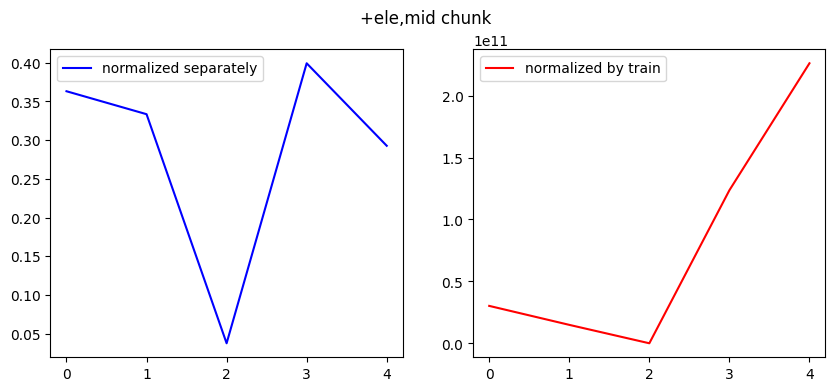

In [ ]:
# ele, mid
midlist0 = spacegener(meanmidele,stdmidele,modelmidele,0,chunksele)
midlist1 = spacegener(meanmidele,stdmidele,modelmidele,1,chunksele)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(midlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(midlist1,label='normalized by train',color='red')
axes[1].legend()

plt.suptitle('+ele,mid chunk')

Text(0.5, 0.98, '+ele,left chunk')

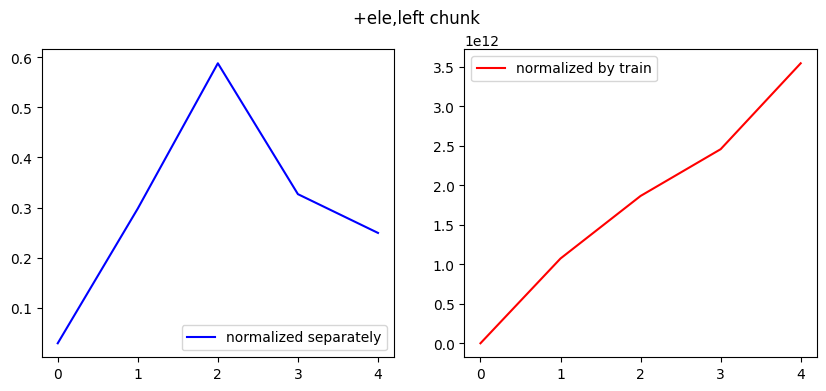

In [ ]:
#ele left
list0 = spacegener(meanleftele,stdleftele,modelleftele,0,chunksele)
list1 = spacegener(meanleftele,stdleftele,modelleftele,1,chunksele)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(list0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(list1,label='normalized by train',color='red')
axes[1].legend()
plt.suptitle('+ele,left chunk')

Text(0.5, 0.98, '+dis,left chunk')

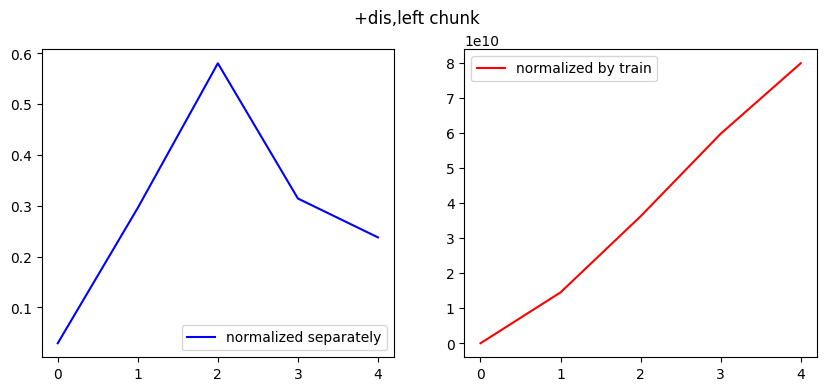

In [ ]:
#dis left
list0 = spacegener(meanleftdis,stdleftdis,modelleftdis,0,chunksdis)
list1 = spacegener(meanleftdis,stdleftdis,modelleftdis,1,chunksdis)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(list0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(list1,label='normalized by train',color='red')
axes[1].legend()
plt.suptitle('+dis,left chunk')

Text(0.5, 0.98, '+ele,right chunk')

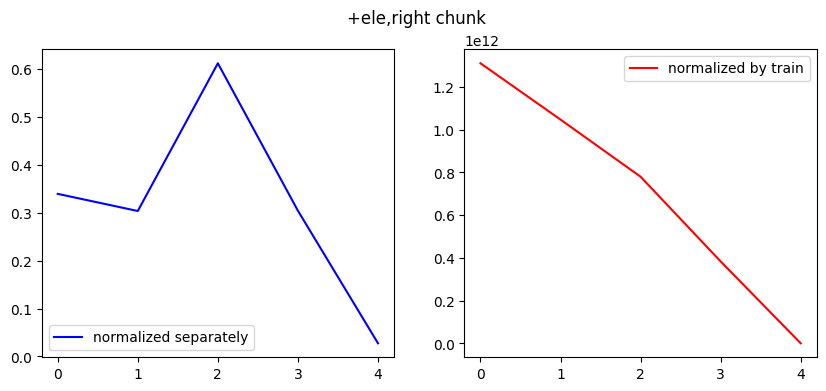

In [ ]:
#ele right
list0 = spacegener(meanrightele,stdrightele,modelrightele,0,chunksele)
list1 = spacegener(meanrightele,stdrightele,modelrightele,1,chunksele)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(list0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(list1,label='normalized by train',color='red')
axes[1].legend()
plt.suptitle('+ele,right chunk')

Text(0.5, 0.98, '+dis,right chunk')

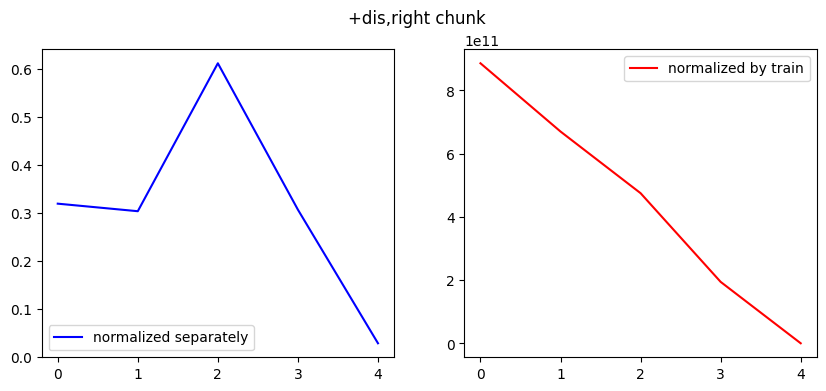

In [ ]:
#dis right
list0 = spacegener(meanrightdis,stdrightdis,modelrightdis,0,chunksdis)
list1 = spacegener(meanrightdis,stdrightdis,modelrightdis,1,chunksdis)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(list0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(list1,label='normalized by train',color='red')
axes[1].legend()
plt.suptitle('+dis,right chunk')

Text(0.5, 0.98, '+dis,mid chunk')

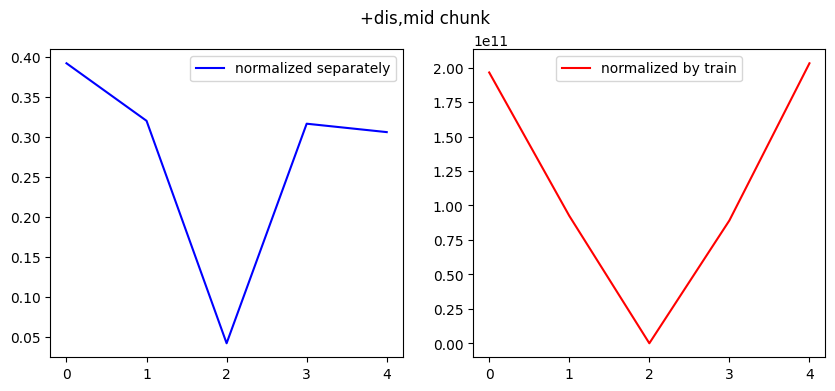

In [ ]:
# dis mid
midlist0 = spacegener(meanmiddis,stdmiddis,modelmiddis,0,chunksdis)
midlist1 = spacegener(meanmiddis,stdmiddis,modelmiddis,1,chunksdis)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(midlist0,label='normalized separately',color='blue')
axes[0].legend()

axes[1].plot(midlist1,label='normalized by train',color='red')
axes[1].legend()
plt.suptitle('+dis,mid chunk')